In [55]:
import numpy as np
from scipy.optimize import fsolve, brentq
from scipy.linalg import lu
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
from math import sin,cos,pi 

In [56]:
# Check if the matrix is diagonally dominant
def check_diaDom(A):
    """Checks if a matrix A is weakly diagonally dominant."""
    n = len(A)
    
    for i in range(n):
        # Get the absolute value of the diagonal element
        diag_val = abs(A[i][i])
        # Calculate the sum of absolute values of off-diagonal elements in the row
        row_sum = sum(abs(A[i][j]) for j in range(n) if j != i)
        
        # If diagonal element is smaller than the sum of others in any row, it's not dominant
        if diag_val < row_sum:
            return False  # Not diagonally dominant
    
    return True  # Matrix is diagonally dominant (weakly)

In [57]:
# Gauss-Seidel Method Implementation with History and Error Tracking
def GS_method(A, b, x_init, max_iterations=100, tolerance=1e-10):
    """
    Solves the linear system Ax = b using the Gauss-Seidel iterative method,
    tracking iteration history and approximate error.

    Args:
        A (numpy.ndarray): The coefficient matrix.
        b (numpy.ndarray): The constant vector.
        x_init (numpy.ndarray): The initial guess for the solution vector.
        max_iterations (int): The maximum number of iterations allowed.
        tolerance (float): The convergence tolerance based on max absolute change.

    Returns:
        tuple: A tuple containing:
            - solution (numpy.ndarray): The computed solution vector.
            - iterations_completed (int): The number of iterations performed.
            - combined_df (pandas.DataFrame): DataFrame tracking x values and
                                              approximate error per iteration.

    Raises:
        ValueError: If matrix A is not square or dimensions mismatch.
        ZeroDivisionError: If a zero diagonal element is encountered.
    """
    n = len(A)
    # --- Input Validation ---
    if A.shape[0] != n or A.shape[1] != n:
         raise ValueError("Matrix A must be square.")
    if b.shape[0] != n:
         raise ValueError("Vector b must have the same number of rows as matrix A.")
    if x_init.shape[0] != n:
         raise ValueError("Initial guess x_init must have the same number of rows as matrix A.")
    # --- End Input Validation ---

    x = x_init.astype(float).copy() # Ensure float type and create a copy
    history = [x.copy()] # Initialize history list with the initial guess (Iteration 0)
    error_history = []   # Initialize list to store error vectors |x_k - x_{k-1}|
    iterations_completed = 0
    converged = False

    for iteration in range(max_iterations):
        x_old = x.copy()

        for i in range(n):
            # Calculate sum of off-diagonal elements * current x values
            sum1 = np.dot(A[i, :i], x[:i])       # Uses already updated x[j] in this iteration (j < i)
            sum2 = np.dot(A[i, i+1:], x_old[i+1:]) # Uses x values from the previous iteration (j > i)

            # Check for zero diagonal element before division
            diag_element = A[i, i]
            if abs(diag_element) < 1e-15: # Use tolerance for zero check
                raise ZeroDivisionError(f"Near-zero diagonal element A[{i}][{i}] encountered at iteration {iteration + 1}.")

            # Update x[i]
            x[i] = (b[i] - sum1 - sum2) / diag_element

        # Calculate and store approximate error AFTER updating x for this iteration
        current_error = np.abs(x - x_old)
        error_history.append(current_error)

        # Store the state *after* completing this iteration
        history.append(x.copy())
        iterations_completed = iteration + 1

        # Check for convergence using infinity norm (max absolute difference)
        # Note: Using np.linalg.norm(current_error, ord=np.inf) is equivalent
        if np.linalg.norm(x - x_old, ord=np.inf) < tolerance:
            converged = True
            break # Exit loop if converged

    # --- Create DataFrames ---
    df_cols = [f'x{i+1}' for i in range(n)] # Dynamic column names for x values
    history_df = pd.DataFrame(history, columns=df_cols)

    # Error DataFrame (index will correspond to iteration number 1, 2, ...)
    error_cols = [f'error_x{i+1}' for i in range(n)] # Dynamic column names for errors
    # error_history has length = iterations_completed
    error_df = pd.DataFrame(error_history, columns=error_cols)
    # Align error index to start from 1 (error after iter 1, 2, ...)
    error_df.index = pd.RangeIndex(1, len(error_history) + 1)

    # Combine history and error DataFrames
    combined_df = history_df.join(error_df)
    combined_df.index.name = 'Iteration' # Index 0 is initial guess

    if not converged:
        print(f"\nWarning: Gauss-Seidel did not converge within {max_iterations} iterations.")

    return x, iterations_completed, combined_df

In [58]:
A = np.array([[0.95, 0.15, 0.20],
    [0.10, 0.85, 0.25],
    [0.25, 0.30, 0.90]])

b = np.array([1.15, 1.10, 1.30]) 


In [59]:
# Check if the matrix is diagonally dominant
try:
    is_diag_dominant = check_diaDom(A)
    print(f"Is matrix diagonally dominant: {is_diag_dominant}")
except ValueError as e:
    print(f"Error checking diagonal dominance: {e}")
    is_diag_dominant = False # Assume not dominant if check fails

# Initial guess
x_init = np.zeros(len(b))

# --- Run and Display ---
try:
    # Solve using Gauss-Seidel method - capture the combined DataFrame
    solution, iterations, combined_df = GS_method(A, b, x_init, max_iterations=100, tolerance=1e-10)

    print(f"\nProcess stopped after {iterations} iterations.")
    print(f"Final x = {solution}")

    # --- Display Iteration History and Error DataFrame ---
    print("\nIteration History and Approx. Error (x1, x2, x3, error_x1, ...):")
    # Optional: Set display options for better readability
    pd.set_option('display.max_rows', 20)  # Show first/last rows if very long
    pd.set_option('display.float_format', '{:.6f}'.format) # Format floats
    print(combined_df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.float_format')
    # --- End Display Iteration History ---

    # Verify the solution by calculating the residual
    residual = b - np.dot(A, solution)
    print(f"\nResidual (b - Ax) at final iteration:")
    print(residual)
    residual_norm = np.linalg.norm(residual)
    print(f"Norm of residual: {residual_norm:.6e}") # Scientific notation

except (ZeroDivisionError, ValueError) as e:
    print(f"\nError during Gauss-Seidel execution: {e}")
    print("Cannot proceed with the calculation.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Is matrix diagonally dominant: True

Process stopped after 13 iterations.
Final x = [0.87619435 0.92884733 0.89144135]

Iteration History and Approx. Error (x1, x2, x3, error_x1, ...):
                x1       x2       x3  error_x1  error_x2  error_x3
Iteration                                                         
0         0.000000 0.000000 0.000000       NaN       NaN       NaN
1         1.210526 1.151703 0.724286  1.210526  1.151703  0.724286
2         0.876197 0.978010 0.875053  0.334329  0.173693  0.150767
3         0.871882 0.934175 0.890863  0.004315  0.043835  0.015810
4         0.875475 0.929102 0.891556  0.003593  0.005073  0.000693
5         0.876130 0.928821 0.891468  0.000655  0.000281  0.000088
6         0.876193 0.928840 0.891444  0.000063  0.000019  0.000024
7         0.876195 0.928846 0.891442  0.000002  0.000007  0.000003
8         0.876194 0.928847 0.891441  0.000000  0.000001  0.000000
9         0.876194 0.928847 0.891441  0.000000  0.000000  0.000000
10        0

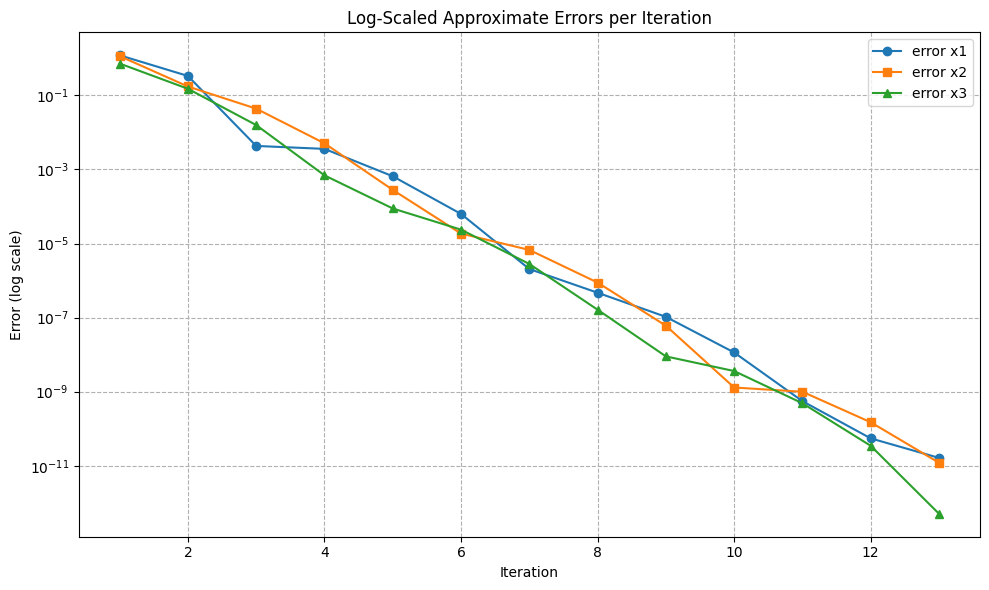

In [60]:
plt.figure(figsize=(10, 6))
plt.semilogy(combined_df.index, combined_df['error_x1'], label='error x1', marker='o')
plt.semilogy(combined_df.index, combined_df['error_x2'], label='error x2', marker='s')
plt.semilogy(combined_df.index, combined_df['error_x3'], label='error x3', marker='^')

plt.title("Log-Scaled Approximate Errors per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error (log scale)")
plt.grid(True, which="both", linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [61]:
plt.semilogy(error_x1, label="error x1")
plt.show()

NameError: name 'error_x1' is not defined

In [62]:
is_diag_dominant = check_diaDom(A)
print(f"Is matrix diagonally dominant: {is_diag_dominant}")

Is matrix diagonally dominant: True


In [63]:
x_init = np.zeros(len(b))
solution, iterations = GS_method(A, b, x_init)

ValueError: too many values to unpack (expected 2)

In [64]:
# Print the results
print(f"\nSolution after {iterations} iterations:")
# Format the solution for better readability
print(f"x = {np.array2string(solution, precision=5, suppress_small=True)}")

# Verify the solution by calculating the residual (Ax - b should be close to 0)
residual = b - np.dot(A, solution)
print(f"\nResidual (b - Ax, should be close to zero):")
# Format the residual for better readability
print(np.array2string(residual, precision=5, suppress_small=True))
# Calculate and print the norm of the residual vector
print(f"Norm of residual: {np.linalg.norm(residual):.5e}")



Solution after 13 iterations:
x = [0.87619 0.92885 0.89144]

Residual (b - Ax, should be close to zero):
[0. 0. 0.]
Norm of residual: 1.91729e-12


In [65]:
# --- System Setup ---
A = np.array([[5, -2, 1],
              [-1, 4, 2],
              [2, 3, -5]], dtype=float)
b = np.array([-0.45, -0.65, -0.85], dtype=float)


# --- LU Decomposition ---
P, L, U = lu(A)

print("Matrix A:")
print(A)
print("\nPermutation Matrix P:")
print(P)
print("\nLower Triangular Matrix L:")
print(L)
print("\nUpper Triangular Matrix U:")
print(U)

Matrix A:
[[ 5. -2.  1.]
 [-1.  4.  2.]
 [ 2.  3. -5.]]

Permutation Matrix P:
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

Lower Triangular Matrix L:
[[ 1.          0.          0.        ]
 [ 0.4         1.          0.        ]
 [-0.2         0.94736842  1.        ]]

Upper Triangular Matrix U:
[[ 5.         -2.          1.        ]
 [ 0.          3.8        -5.4       ]
 [ 0.          0.          7.31578947]]


In [66]:
# --- Verify PA = LU ---
PA = P @ A
LU = L @ U
print("\nVerification: PA and LU difference")
print(PA - LU)

# --- Solve Ly = Pb ---
Pb = np.dot(P, b)
y = np.zeros_like(b)

for i in range(len(y)):
    y[i] = Pb[i] - np.dot(L[i, :i], y[:i])

# --- Solve Ux = y ---
x = np.zeros_like(b)

for i in range(len(x)-1, -1, -1):
    x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]

print("\n✅ Final Solution from LU Decomposition:")
print(f"x1 = {x[0]:.6f}, x2 = {x[1]:.6f}, x3 = {x[2]:.6f}")

# --- Direct Solver Comparison ---
x_direct = np.linalg.solve(A, b)
print("\n✅ Solution from np.linalg.solve:")
print(f"x1 = {x_direct[0]:.6f}, x2 = {x_direct[1]:.6f}, x3 = {x_direct[2]:.6f}")

# --- Compare Difference ---
diff = np.abs(x_direct - x)
print("\n🔍 Absolute difference between LU and Direct method:")
print(diff)

# --- Optional: Residual norm ---
residual = np.linalg.norm(A @ x - b)
print("\n📉 Residual norm (||Ax - b||):")
print(residual)


Verification: PA and LU difference
[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 4.4408921e-16 0.0000000e+00]]

✅ Final Solution from LU Decomposition:
x1 = -0.165827, x2 = -0.196763, x3 = -0.014388

✅ Solution from np.linalg.solve:
x1 = -0.165827, x2 = -0.196763, x3 = -0.014388

🔍 Absolute difference between LU and Direct method:
[0. 0. 0.]

📉 Residual norm (||Ax - b||):
1.5700924586837752e-16


<Axes: ylabel='Iteration'>

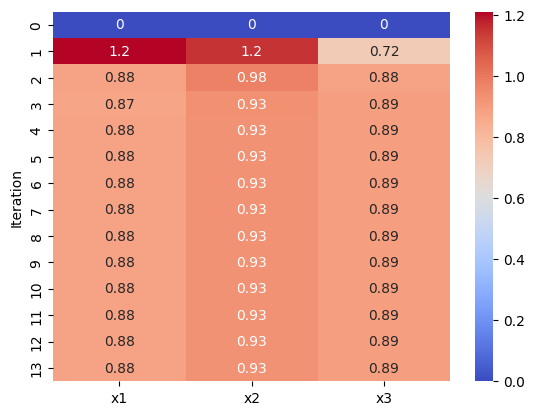

In [67]:
import seaborn as sns
sns.heatmap(combined_df[['x1', 'x2', 'x3']], annot=True, cmap="coolwarm")

NameError: name 'error_x1' is not defined